In [1]:
import torch
import torch.nn
import torch.utils
import torch.utils.data
import torch.nn.functional as F
import fine_tune
import numpy as np
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
import pandas as pd 

In [2]:
TASK = 'qnli'
TEACHER_EXP = 'teacher_base'
TMODEL = 'bert'
TCKPT = 9822
STUDENT_EXP = 'PKD2'
SMODEL = 'bert'
SCKPT = 13000
DATASET = 'train'
SDEVICE = 0
TDEVICE = 0
BATCH_SIZE = 1

In [3]:
teacher_config = fine_tune.config.TeacherConfig.load(
    experiment=TEACHER_EXP,
    model=TMODEL,
    task=TASK
)
teacher_config.device_id = TDEVICE
teacher_config.dataset = DATASET
print(teacher_config)


+---------------------------------------+
| configuration     | value             |
+---------------------------------------+
| accum_step        | 2                 |
| amp               | 0                 |
| batch_size        | 32                |
| beta1             | 0.9               |
| beta2             | 0.999             |
| ckpt_step         | 1000              |
| dataset           | train             |
| device_id         | 0                 |
| dropout           | 0.1               |
| eps               | 1e-08             |
| experiment        | teacher_base      |
| log_step          | 500               |
| lr                | 3e-05             |
| max_norm          | 1.0               |
| max_seq_len       | 128               |
| model             | bert              |
| num_class         | 2                 |
| ptrain_ver        | bert-base-uncased |
| seed              | 42                |
| task              | qnli              |
| total_step        | 9822       

In [4]:
fine_tune.util.set_seed_by_config(teacher_config)

In [5]:
student_config = fine_tune.config.StudentConfig.load(
    experiment=STUDENT_EXP,
    model=SMODEL,
    task=TASK
)
student_config.device_id = SDEVICE
student_config.dataset = DATASET
print(student_config)


+-------------------------------------------+
| configuration       | value               |
+-------------------------------------------+
| accum_step          | 1                   |
| amp                 | 0                   |
| batch_size          | 32                  |
| beta1               | 0.9                 |
| beta2               | 0.999               |
| ckpt_step           | 1000                |
| d_emb               | 128                 |
| d_ff                | 3072                |
| d_model             | 768                 |
| dataset             | train               |
| device_id           | 0                   |
| dropout             | 0.1                 |
| eps                 | 1e-08               |
| experiment          | PKD2                |
| log_step            | 100                 |
| lr                  | 5e-05               |
| max_norm            | 1.0                 |
| max_seq_len         | 128                 |
| model               | bert     

In [6]:
dataset = fine_tune.util.load_dataset_by_config(
    config=teacher_config
)

2021/05/22 02:11:50 - INFO - fine_tune.task -   Start loading task QNLI dataset train.
Loading QNLI train: 104743it [00:00, 590392.41it/s]
2021/05/22 02:11:50 - INFO - fine_tune.task -   Number of samples: 104743
2021/05/22 02:11:50 - INFO - fine_tune.task -   Finish loading task QNLI dataset train.


In [7]:
teacher_tknr = fine_tune.util.load_teacher_tokenizer_by_config(
    config=teacher_config
)
student_tknr = fine_tune.util.load_student_tokenizer_by_config(
    config=student_config
)

In [8]:
TEACHER_EXP_NAME = fine_tune.config.BaseConfig.experiment_name(
    experiment=teacher_config.experiment,
    model=teacher_config.model,
    task=teacher_config.task
)
TEACHER_EXP_DIR = os.path.join(
    fine_tune.path.FINE_TUNE_EXPERIMENT,
    TEACHER_EXP_NAME
)
print(TEACHER_EXP_DIR)

/home/kychen/Desktop/BERT-gang/data/fine_tune_experiment/teacher_base_bert_qnli


In [9]:
teacher_model = fine_tune.util.load_teacher_model_by_config(
    config=teacher_config
)
teacher_model.load_state_dict(
    torch.load(
        os.path.join(TEACHER_EXP_DIR, f'model-{TCKPT}.pt'),
        map_location=teacher_config.device
    )
)

<All keys matched successfully>

In [10]:
STUDENT_EXP_NAME = fine_tune.config.BaseConfig.experiment_name(
    experiment=student_config.experiment,
    model=student_config.model,
    task=student_config.task
)
STUDENT_EXP_DIR = os.path.join(
    fine_tune.path.FINE_TUNE_EXPERIMENT,
    STUDENT_EXP_NAME
)
print(STUDENT_EXP_DIR)

/home/kychen/Desktop/BERT-gang/data/fine_tune_experiment/PKD2_bert_qnli


In [11]:
student_model = fine_tune.util.load_student_model_by_config(
    config=student_config,
    tokenizer=student_tknr,
    init_from_pre_trained=False
)
student_model.load_state_dict(
    torch.load(
        os.path.join(STUDENT_EXP_DIR, f'model-{SCKPT}.pt'),
        map_location=student_config.device
    )
)

<All keys matched successfully>

In [12]:
dataloader = torch.utils.data.DataLoader(
    dataset,
    collate_fn=dataset.create_collate_fn(),
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [13]:
cosine_sim = torch.nn.CosineSimilarity()

y_ground = []
y_teacher = []
y_student = []

cosine_sim_df = pd.DataFrame(columns=['cosine_sim', 'pred_relation'])

In [14]:
student_model.eval()
teacher_model.eval()


with torch.no_grad():
    for text, text_pair, label in tqdm(dataloader):
        teacher_encode = teacher_tknr(
            text=text,
            text_pair=text_pair,
            padding='max_length',
            max_length=teacher_config.max_seq_len,
            return_tensors='pt',
            truncation=True
        )
        teacher_input_ids = teacher_encode['input_ids']
        teacher_token_type_ids = teacher_encode['token_type_ids']
        teacher_attention_mask = teacher_encode['attention_mask']

        student_encode = student_tknr(
            text=text,
            text_pair=text_pair,
            padding='max_length',
            max_length=student_config.max_seq_len,
            return_tensors='pt',
            truncation=True
        )
        student_input_ids = student_encode['input_ids']
        student_token_type_ids = student_encode['token_type_ids']
        student_attention_mask = student_encode['attention_mask']

        t_logits, t_cls = teacher_model(
            input_ids = teacher_input_ids.to(teacher_config.device),
            token_type_ids = teacher_token_type_ids.to(teacher_config.device),
            attention_mask = teacher_attention_mask.to(teacher_config.device)
        )

        s_logits, s_cls = student_model(
            input_ids = student_input_ids.to(student_config.device),
            token_type_ids = student_token_type_ids.to(student_config.device),
            attention_mask = student_attention_mask.to(student_config.device)
        )

        gt = label[-1]
        t_pred_label = F.softmax(t_logits, dim=-1).argmax(dim=-1).to('cpu').detach().item()
        s_pred_label = F.softmax(s_logits, dim=-1).argmax(dim=-1).to('cpu').detach().item()


        y_ground.append(gt)
        y_teacher.append(t_pred_label)
        y_student.append(s_pred_label)

        if gt == t_pred_label and gt == s_pred_label:
            cosine_sim_df = cosine_sim_df.append(
                {
                    'cosine_sim': cosine_sim(s_cls, t_cls).to('cpu').detach().item(),
                    'pred_relation': 'both_correct'
                },
                ignore_index = True
            )
            
        elif gt == t_pred_label and gt != s_pred_label:
            cosine_sim_df = cosine_sim_df.append(
                {
                    'cosine_sim': cosine_sim(s_cls, t_cls).to('cpu').detach().item(),
                    'pred_relation': 'student_incorrect'
                },
                ignore_index = True
            )
        elif gt != t_pred_label and gt == s_pred_label:
            cosine_sim_df = cosine_sim_df.append(
                {
                    'cosine_sim': cosine_sim(s_cls, t_cls).to('cpu').detach().item(),
                    'pred_relation': 'teacher_incorrect'
                },
                ignore_index = True
            )
        else:
            cosine_sim_df = cosine_sim_df.append(
                {
                    'cosine_sim': cosine_sim(s_cls, t_cls).to('cpu').detach().item(),
                    'pred_relation': 'both_incorrect'
                },
                ignore_index = True
            )
            

    


100%|██████████| 104743/104743 [21:41<00:00, 80.49it/s]


## Confusion matrix of teacher and student outputs

In [15]:
cm = confusion_matrix(y_teacher, y_student)

In [16]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

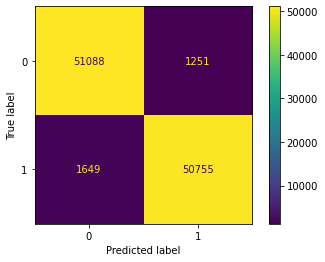

In [17]:
disp.plot(values_format='d')

## Confusion matrix of teacher and ground truth

In [18]:
cm2 = confusion_matrix(y_ground, y_teacher)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2)

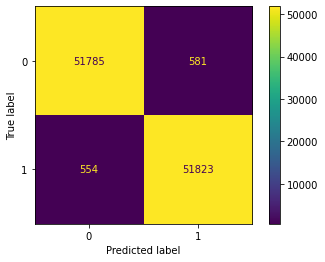

In [19]:
disp2.plot(values_format='d')

## Confusion matrix of student and ground truth

In [20]:
cm3 = confusion_matrix(y_ground, y_student)
disp3 = ConfusionMatrixDisplay(confusion_matrix=cm3)

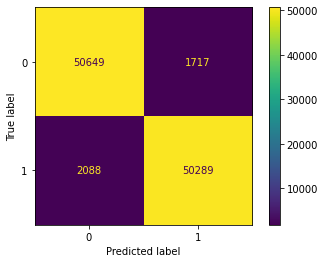

In [21]:
disp3.plot(values_format='d')

In [22]:
t_acc = accuracy_score(y_ground, y_teacher)
print(t_acc)

0.9891639536770954


In [23]:
s_acc = accuracy_score(y_ground, y_student)
print(s_acc)

0.9636729900804827


# Plot CLS embedding distribution

In [24]:
import seaborn as sns

In [25]:
cosine_sim_df

,cosine_sim,pred_relation
0,0.602634,both_correct
1,0.793007,both_correct
2,0.864885,both_correct
3,0.669374,both_correct
4,-0.571031,student_incorrect
...,...,...
104738,0.781200,both_correct
104739,0.661879,both_correct
104740,0.889054,both_correct
104741,0.814998,both_correct


## Overview distribution

In [26]:
cosine_sim_df['pred_relation'].value_counts()

both_correct         100823
student_incorrect      2785
both_incorrect         1020
teacher_incorrect       115
Name: pred_relation, dtype: int64

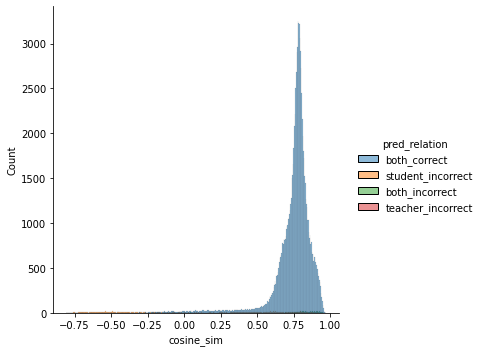

In [27]:
sns.displot(cosine_sim_df, x='cosine_sim', hue='pred_relation')

## Both correct

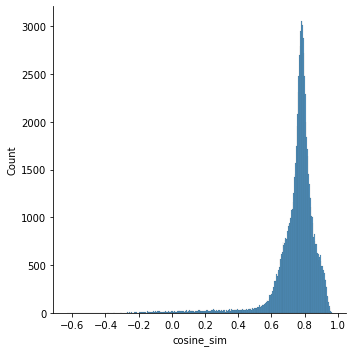

In [28]:
sns.displot(cosine_sim_df.loc[cosine_sim_df['pred_relation']=='both_correct'], x='cosine_sim')

## Teacher correct, student incorrect

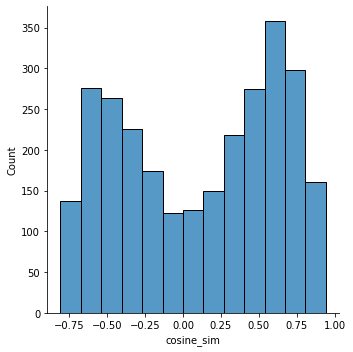

In [29]:
sns.displot(cosine_sim_df.loc[cosine_sim_df['pred_relation']=='student_incorrect'], x='cosine_sim')

## Teacher incorrect, student correct

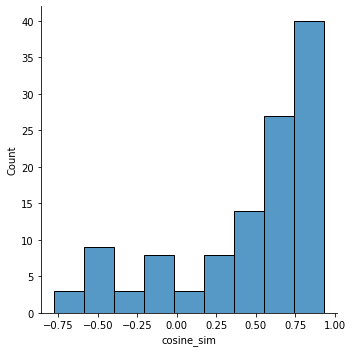

In [30]:
sns.displot(cosine_sim_df.loc[cosine_sim_df['pred_relation']=='teacher_incorrect'], x='cosine_sim')

## Both incorrect

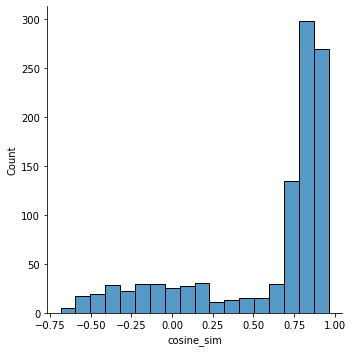

In [31]:
sns.displot(cosine_sim_df.loc[cosine_sim_df['pred_relation']=='both_incorrect'], x='cosine_sim')